In [16]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git

  Cloning https://github.com/rongardF/tvdatafeed.git to /tmp/pip-req-build-kg5kupnr
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed.git /tmp/pip-req-build-kg5kupnr
  Resolved https://github.com/rongardF/tvdatafeed.git to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done


In [17]:
import math
def CRRTree(K,T,S,sig,r,N,PorC):

    dt=T/N;
    dxu=math.exp((r-(sig**2/2))*dt+sig*math.sqrt(dt));
    dxd=math.exp((r-(sig**2/2))*dt-sig*math.sqrt(dt));
    #risk-neutral evaluation
    pu=0.5;
    pd=1-pu;
    disc=math.exp(-r*dt);

    St = [0] * (N+1)
    C = [0] * (N+1)

    St[0]=S*dxd**N;

    for j in range(1, N+1):
        St[j] = St[j-1] * dxu/dxd;

    for j in range(1, N+1):
        if PorC == 'p':
            C[j] = max(K-St[j],0);
        elif PorC == 'c':
            C[j] = max(St[j]-K,0);

    for i in range(N, 0, -1):
        for j in range(0, i):
            C[j] = disc*(pu*C[j+1]+pd*C[j]);
    return C[0]

In [18]:
import math

def fnor2(x):

    y=0.5*(1+math.erf(x/math.sqrt(2)));

    return y

def BS(t,St,K,T,r,sig,PorC):

    Tmt=T-t;
    ATmt=sig*math.sqrt(Tmt);
    logo=math.log(St/K);
    Ap=(logo+(r+0.5*sig**2)*Tmt)/ATmt;
    An=Ap-ATmt;

    if PorC == 'c':
        p=St*fnor2(Ap)-K*math.exp(-r*Tmt)*fnor2(An);
    elif PorC == 'p':
        p=K*math.exp(-r*Tmt)*fnor2(-An)-St*fnor2(-Ap);

    return p

In [19]:
!pip install dataframe_image

In [21]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  #To ignore log in warnings
from tvDatafeed import TvDatafeed, Interval ##used to get the historical data
import random
import dataframe_image as dfi

## top 10 stocks
n50=np.array(['NIFTY','HINDALCO','MARUTI','NESTLEIND', 'ONGC', 'TATAMOTORS','ITC','SUNPHARMA','BHARATIARTL','CIPLA'])

def predict(bt_N,b):
  result=pd.DataFrame(columns=['Date','Start', 'Strike', 'Market Premium', 'BS Premium', 'BT Premium', 'BS Error', 'BT Error', 'BS Percent Error', 'BT Percent Error'])
  tv=TvDatafeed()
  data=tv.get_hist(symbol=n50[b],exchange='NSE',interval=Interval.in_daily,n_bars=1100)
  df=pd.DataFrame(data)
  datatoexcel = pd.ExcelWriter('NIFTYdata.xlsx')
  df.to_excel(datatoexcel)
  datatoexcel.close()
  print('DataFrame is written to Excel File successfully.')
  vd=252 ##offset for volatility
  rf=0.0695  ## risk free rate
  df=df.drop(['symbol','high','low','volume'],axis=1)
  df.reset_index(inplace=True)
  df['datetime']=pd.to_datetime(df['datetime'])
  df['day_of_week']=df['datetime'].dt.day_of_week ## if day of week is 3, it is thursday
  df['date']=df['datetime'].dt.day
  df['daily_return']=np.log(df['close']/df['open'])
  #The data of the Stock displayed
  # display(df.head())
  act_index=[]
  for i in range(1080-vd):
    if df.loc[i+vd,'date'] > df.loc[i+vd+1,'date']:
      flag=False
      for j in range(5):
        if df.loc[i+vd-j,'day_of_week'] == 3:
          act_index.append(i+vd-j)
          flag=True
          break
      ## incase the given thursadayis a holiday, we would check on the friday. this ensures that we dont skip any month
      ## due to lack of thursday data in the dataframe
      if flag==False:
        for j in range(5):
          if df.loc[i+vd-j,'day_of_week'] == 4:
            act_index.append(i+vd-j)
            flag=True
            break
  #print(len(act_index))
  #print(df.loc[act_index])
  #print(df[410:420])
  ## now calculating for each index/month

  volatil=pd.DataFrame(columns=['Date','Volatility'])
  for e in range(39):
    start_index=act_index[e]
    start_price=df.loc[start_index,'open']

    #Volatility Calculation
    vol=df.loc[start_index-252:start_index,'daily_return']
    vol=vol.to_numpy()
    sigma=vol.std()*np.sqrt(252)
    volatil.loc[len(volatil)] ={
      'Date': df.loc[start_index + 1, 'datetime'],
      'Volatility': sigma
    }
    #print(sigma)

    #Calculation for different possible strike prices
    for num_of_sps in range(-3,4):
      strike_price=start_price+num_of_sps*(start_price/10)
      bs_premium=BS(0,start_price,strike_price,1.0/12,rf,sigma,'c')
      bt_premium=CRRTree(strike_price,1.0/12,start_price,sigma,rf,bt_N,'c')
      market_premium=max(0,df.loc[start_index+1,'open']-strike_price)
      bs_error = abs(bs_premium - market_premium)
      bt_error = abs(bt_premium - market_premium)
      bs_percent_error = 0
      bt_percent_error = 0
      if market_premium == 0:
        if bs_error >= 10:
          bs_percent_error = 100
        if bt_error >=10:
          bt_percent_error = 100
      else:
        bs_percent_error = min((bs_error / market_premium)*100,100)
        bt_percent_error = min((bt_error / market_premium)*100,100)
      result.loc[len(result)] ={
        'Date': df.loc[start_index + 1, 'datetime'],
        'Start': start_price,
        'Strike': strike_price,
        'Market Premium': market_premium,
        'BS Premium': bs_premium,
        'BT Premium': bt_premium,
        'BS Error': bs_error,
        'BT Error': bt_error,
        'BS Percent Error': bs_percent_error,
        'BT Percent Error': bt_percent_error
      }
  result.set_index('Date', inplace=True)
  volatil.set_index('Date', inplace=True)
  return result,volatil



In [22]:

#Setting the stock to be analysed
b=0
N=6
print(f"\033[1mThe underlying asset is: {n50[b]}\033[0m")


The underlying asset is: NIFTY


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


DataFrame is written to Excel File successfully.


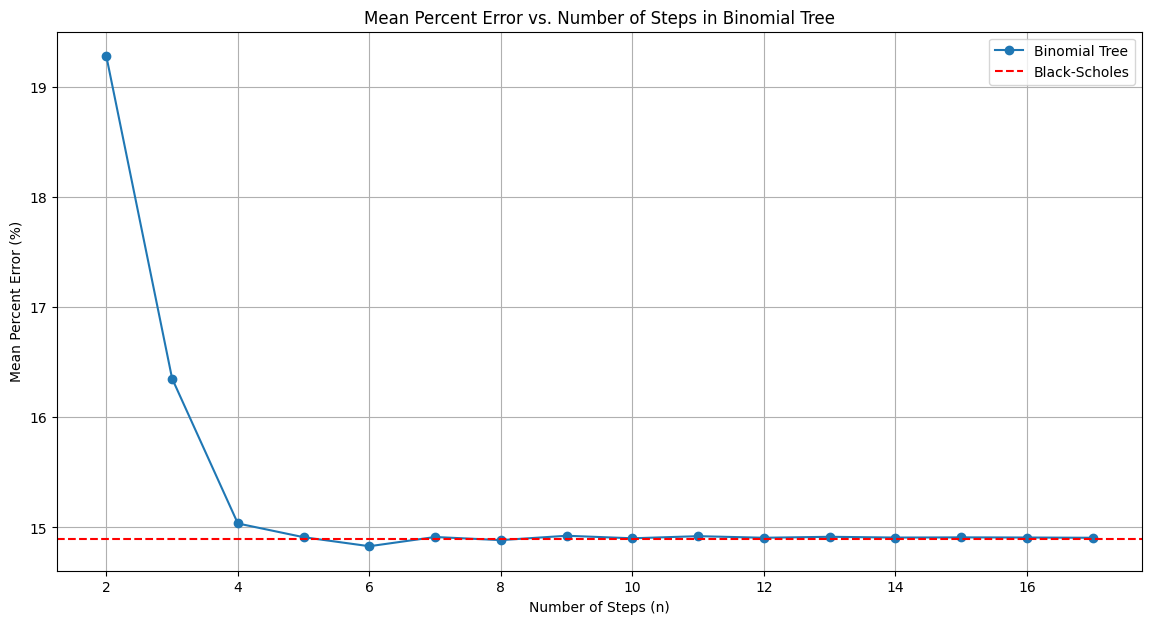

In [23]:

#Plotting performance of binomial tress against the number of steps
n_values = range(2, 18)
bt_mean_percent_errors = []
for n in n_values:
    result = predict(n,b)[0]
    aresult = result.groupby(result.index).mean()
    bt_mean_percent_errors.append(aresult['BT Percent Error'].mean())

# Calculate mean percent error for Black-Scholes
bs_mean_percent_error = aresult['BS Percent Error'].mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(n_values, bt_mean_percent_errors, marker='o', label='Binomial Tree')
plt.axhline(y=bs_mean_percent_error, color='r', linestyle='--', label='Black-Scholes')
plt.xlabel('Number of Steps (n)')
plt.ylabel('Mean Percent Error (%)')
plt.title('Mean Percent Error vs. Number of Steps in Binomial Tree')
plt.legend()
plt.grid(True)
plt.show()


In [11]:

#Result display
result=predict(N,b)[0]
display(result)

aresult = result.groupby(result.index).mean().tail(26)       #Aggregated result of all different strike prices for a single date, for last 2 yrs
display(aresult)


,Start,Strike,Market Premium,BS Premium,BT Premium,BS Error,BT Error,BS Percent Error,BT Percent Error
Date,,,,,,,,,
2021-03-26 03:45:00,14570.900,10199.6300,4306.6700,4.430172e+03,4391.848900,1.235021e+02,85.178900,2.867694,1.977837
2021-03-26 03:45:00,14570.900,11656.7200,2849.5800,2.981506e+03,2965.809042,1.319255e+02,116.229042,4.629648,4.078813
2021-03-26 03:45:00,14570.900,13113.8100,1392.4900,1.542043e+03,1539.769185,1.495535e+02,147.279185,10.740002,10.576678
2021-03-26 03:45:00,14570.900,14570.9000,0.0000,3.847332e+02,379.241438,3.847332e+02,379.241438,100.000000,100.000000
2021-03-26 03:45:00,14570.900,16027.9900,0.0000,2.501799e+01,20.769169,2.501799e+01,20.769169,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...
2024-05-31 03:45:00,22617.449,20355.7041,2212.3959,2.379298e+03,2363.410194,1.669023e+02,151.014294,7.543962,6.825826
2024-05-31 03:45:00,22617.449,22617.4490,0.0000,2.982975e+02,303.016508,2.982975e+02,303.016508,100.000000,100.000000
2024-05-31 03:45:00,22617.449,24879.1939,0.0000,2.888521e-02,0.000000,2.888521e-02,0.000000,0.000000,0.000000


,Start,Strike,Market Premium,BS Premium,BT Premium,BS Error,BT Error,BS Percent Error,BT Percent Error
Date,,,,,,,,,
2022-04-29 03:45:00,17189.500,17189.500,1553.242857,1548.913912,1534.854453,47.358950,61.609185,15.102819,15.444701
2022-05-27 03:45:00,16105.000,16105.000,1489.914286,1452.569400,1439.637269,63.064325,75.959538,8.320904,8.730536
2022-07-01 03:45:00,15774.500,15774.500,1321.757143,1423.893160,1411.443050,102.136017,89.685907,16.814445,16.475022
2022-07-29 03:45:00,16774.850,16774.850,1611.930000,1514.927375,1501.865322,97.613563,110.506841,3.089621,3.421355
2022-08-26 03:45:00,17679.000,17679.000,1489.757571,1596.919006,1583.231653,107.161434,93.474082,16.494614,16.166206
2022-09-30 03:45:00,16993.600,16993.600,1372.787571,1535.914257,1522.959716,163.126686,150.172144,18.978660,18.644632
2022-10-28 03:45:00,17771.400,17771.400,1516.834286,1606.925921,1593.528323,90.091636,76.694038,15.785652,15.473929
2022-11-25 03:45:00,18326.100,18326.100,1686.436571,1656.399003,1642.439623,70.702851,84.453504,11.349286,11.674363
2022-12-30 03:45:00,18045.699,18045.699,1668.717629,1629.060935,1614.856771,71.721784,85.744347,9.069591,9.442830


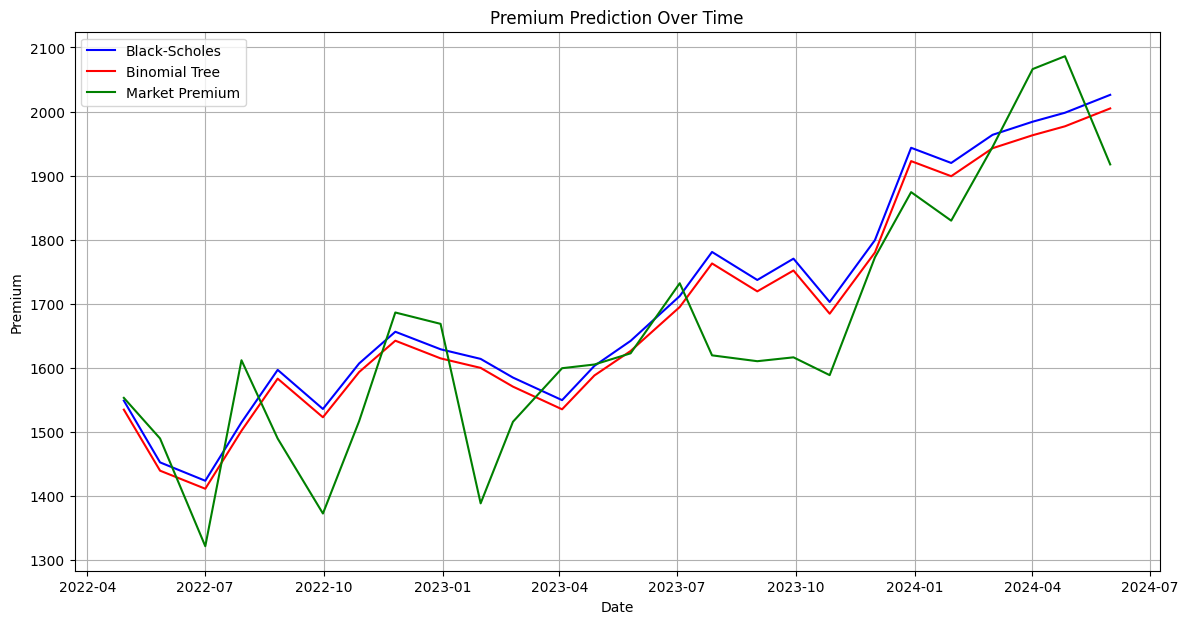

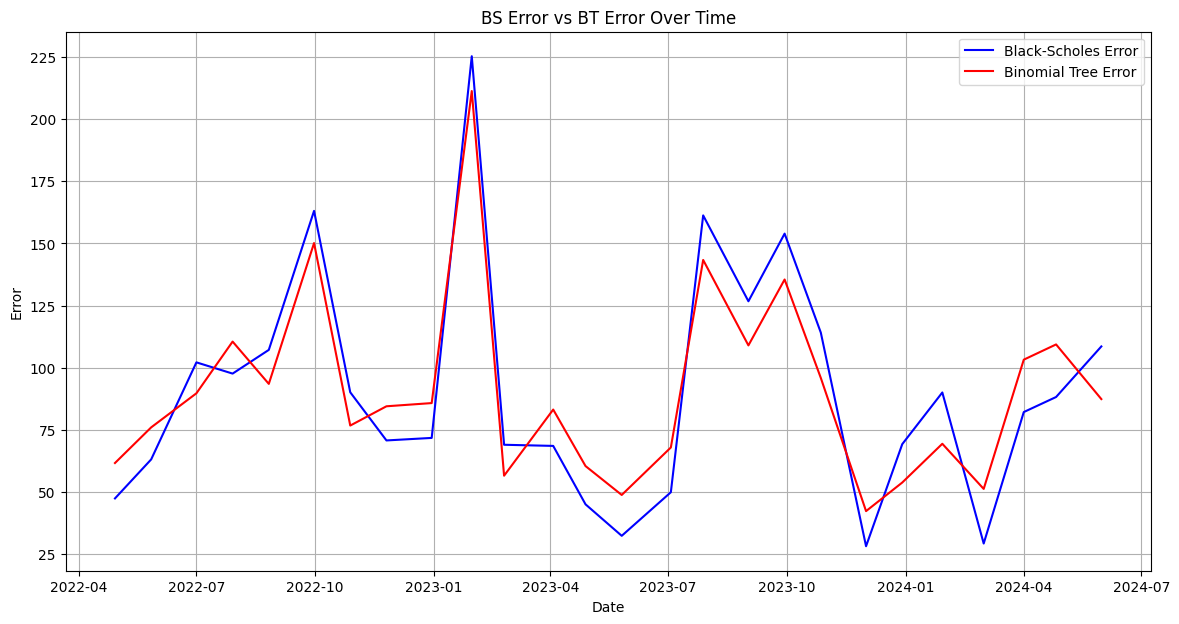

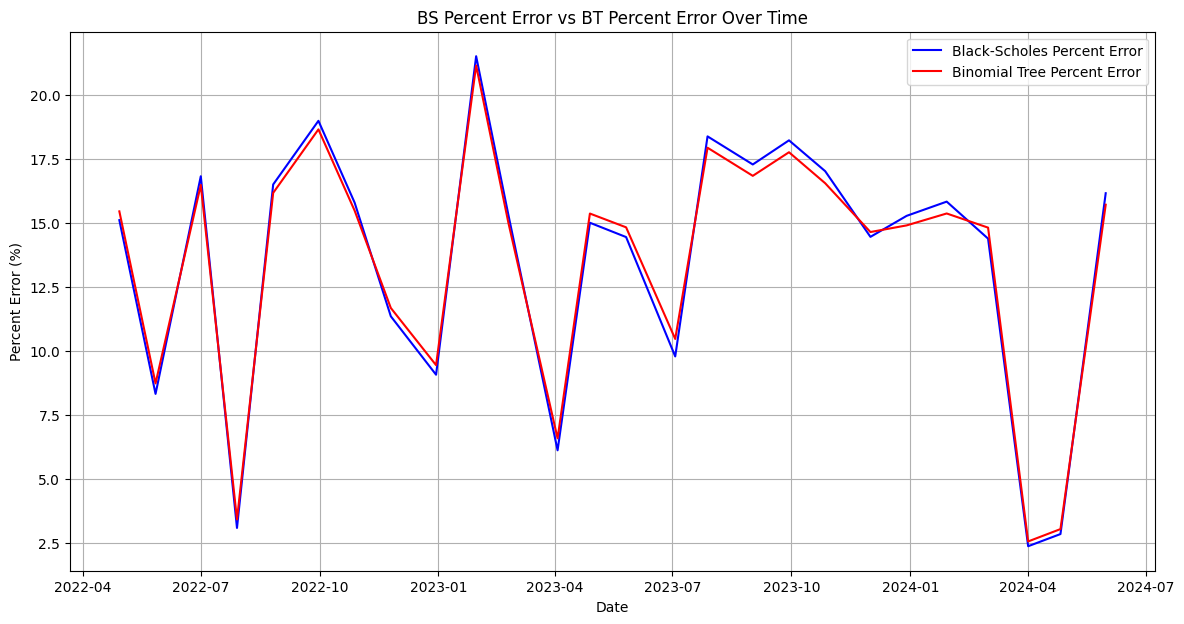

Mean Error Black-Scholes:  94.20297413489938
Mean Error Binomial:  92.30727556995615
Mean Percent Error Black-Scholes:  14.891431071575113
Mean Percent Error Binomial:  14.829353231560376


In [12]:

# Plotting premium prediction vs market premium
plt.figure(figsize=(14, 7))
plt.plot(aresult.index, aresult['BS Premium'], label='Black-Scholes', color='blue')
plt.plot(aresult.index, aresult['BT Premium'], label='Binomial Tree', color='red')
plt.plot(aresult.index, aresult['Market Premium'], label='Market Premium', color='green')
plt.xlabel('Date')
plt.ylabel('Premium')
plt.title('Premium Prediction Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the errors vs time
plt.figure(figsize=(14, 7))
plt.plot(aresult.index, aresult['BS Error'], label='Black-Scholes Error', color='blue')
plt.plot(aresult.index, aresult['BT Error'], label='Binomial Tree Error', color='red')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('BS Error vs BT Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the percent errors vs time
plt.figure(figsize=(14, 7))
plt.plot(aresult.index, aresult['BS Percent Error'], label='Black-Scholes Percent Error', color='blue')
plt.plot(aresult.index, aresult['BT Percent Error'], label='Binomial Tree Percent Error', color='red')
plt.xlabel('Date')
plt.ylabel('Percent Error (%)')
plt.title('BS Percent Error vs BT Percent Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

print("Mean Error Black-Scholes: ", result['BS Error'].mean())
print("Mean Error Binomial: ", result['BT Error'].mean())
print("Mean Percent Error Black-Scholes: ", result['BS Percent Error'].mean())
print("Mean Percent Error Binomial: ", result['BT Percent Error'].mean())


,Volatility
Date,
2022-04-29 03:45:00,0.119803
2022-05-27 03:45:00,0.124840
2022-07-01 03:45:00,0.129009
2022-07-29 03:45:00,0.131532
2022-08-26 03:45:00,0.132623
2022-09-30 03:45:00,0.135644
2022-10-28 03:45:00,0.137891
2022-11-25 03:45:00,0.135800
2022-12-30 03:45:00,0.129510


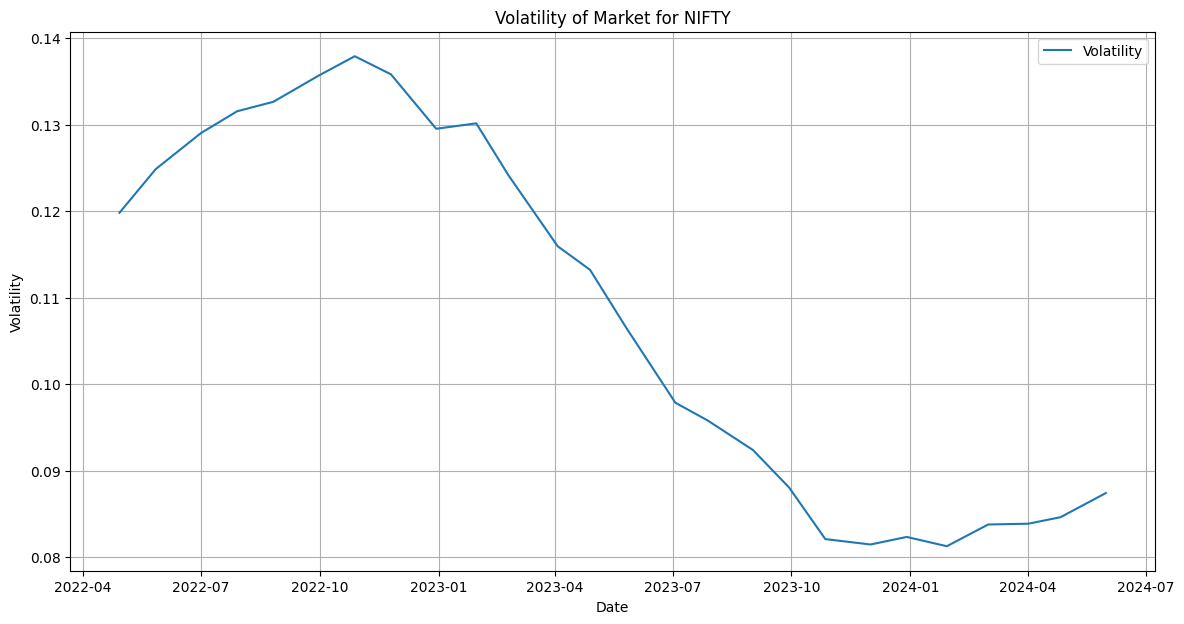

In [13]:

# Plotting the results

#Volatility of Market for the stock
volatil=predict(N,b)[1].tail(26)
display(volatil)
plt.figure(figsize=(14, 7))
plt.plot(volatil.index, volatil['Volatility'], label='Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title(f'Volatility of Market for {n50[b]}')
plt.legend()
plt.grid(True)
plt.show()


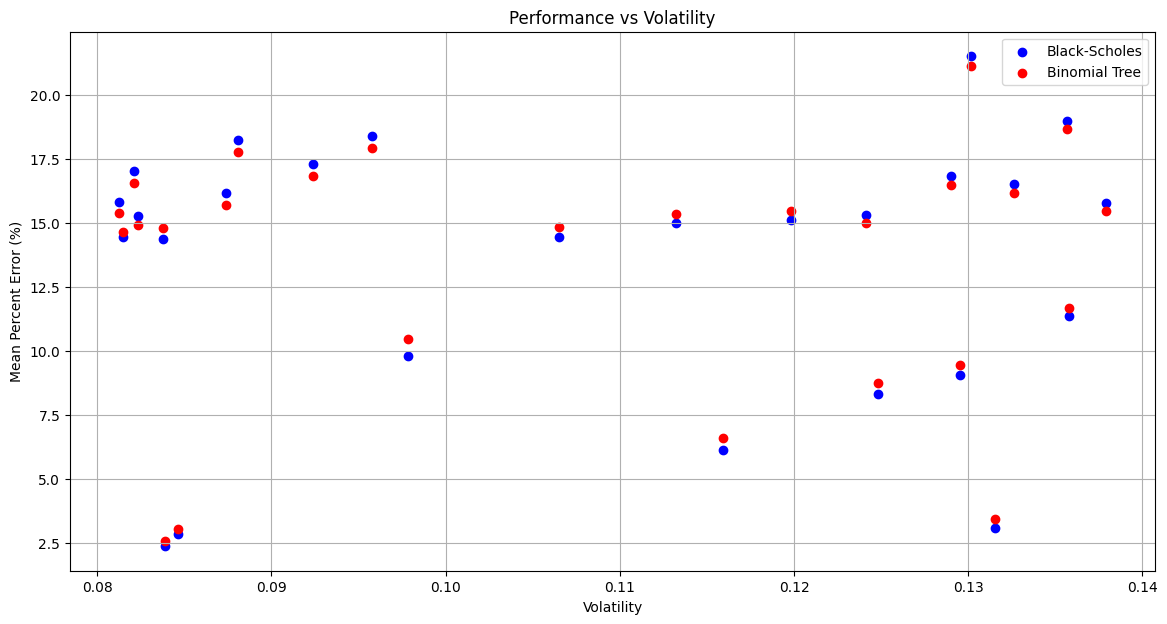

In [14]:

# Plot performance vs volatility
plt.figure(figsize=(14, 7))
plt.scatter(volatil['Volatility'], aresult['BS Percent Error'], label='Black-Scholes', color='blue')
plt.scatter(volatil['Volatility'], aresult['BT Percent Error'], label='Binomial Tree', color='red')
plt.xlabel('Volatility')
plt.ylabel('Mean Percent Error (%)')
plt.title('Performance vs Volatility')
plt.legend()
plt.grid(True)
plt.show()